In [1]:
import pandas as pd
import numpy as np

data = pd.read_excel('../data/record50.xlsx', sheet_name=1, header=0, index_col=0)
data

,歌曲（4/4拍·抒情流行音乐）,歌曲转折时间点,开头/前奏 Introduction,主歌 Verse,预副歌 Pre-chorus,副歌 Chorus,桥段 Bridge,结尾 Outro/Conclusion,乐器独奏 ElisionInstrumental Solo
序号,,,,,,,,,
0,彩虹,"00:00 , 00:12 , 01:29 , 01:56 , 02:47 , 03:14 ...",00:00-00:12,00:12-01:29\n01:56-02:47,NaN,01:29-01:56\n02:47-03:14\n03:38-04:09,03:14-03:38,04:09-04:23,(此列暂时不用)
1,孤独患者,NaN,00:00-00:16\n01:31-01:39\n02:54-03:21,00:16-00:48\n01:39-02:09,NaN,00:48-01:31\n02:09-02:54\n03:21-04:07,NaN,04:07-04:32,NaN
2,你的背包,NaN,00:00-00:22\n01:21-01:26\n02:25-02:49,00:22-00:52\n01:26-01:56,NaN,00:52-01:21\n01:56-02:25\n02:49-03:30,NaN,03:30-03:57,NaN
3,伤信,NaN,00:00-00:23,NaN,NaN,NaN,NaN,NaN,NaN
4,淘汰,NaN,00:00-00:34\n02:10-02:24\n03:28-03:43,00:34-01:37\n02:24-02:54,NaN,01:37-02:10\n02:54-03:28\n03:43-04:18,NaN,04:18-04:45,NaN
5,K歌之王,NaN,00:00-00:13\n01:44-01:54,00:13-01:03\n01:54-02:20,NaN,01:03-01:44\n02:20-02:43\n02:55-03:07,02:43-02:55,03:07-03:38,NaN
6,我总是一个人在练习一个人,NaN,00:00-00:14\n01:48-02:03,00:14-01:14,NaN,01:14-01:48\n02:03-02:36,NaN,02:36-03:03,NaN
7,石榴石,NaN,00:00-00:12\n01:44-01:50\n03:23-03:44,00:12-00:41\n01:50-02:19,00:41-01:05\n02:19-02:43\n03:44-04:12,01:05-01:44\n02:43-03:23\n04:12-04:43,NaN,04:43-05:19,NaN
8,老人与海,NaN,00:00-00:36\n02:46-03:07,00:36-00:58\n01:41-02:03\n03:07-03:30,NaN,01:19-01:41\n02:24-02:46,00:58-01:19\n02:03-02:24,03:30-04:27,NaN


In [2]:
recordpoint = []
for i in range(data.shape[0]):
    d = data.iloc[i].values
    tmp = []
    for s in d[2:-1]:
        if s is np.nan:
            continue
        s = s.split('\n')
        for si in s:
            st = si.split('-')
            for t in st:
                if t not in tmp:
                    tmp.append(t)
    tmp = sorted(tmp)
    recordpoint.append(",".join(tmp))
    
data['歌曲转折时间点'] = pd.Series(recordpoint, index=data.index)
data

,歌曲（4/4拍·抒情流行音乐）,歌曲转折时间点,开头/前奏 Introduction,主歌 Verse,预副歌 Pre-chorus,副歌 Chorus,桥段 Bridge,结尾 Outro/Conclusion,乐器独奏 ElisionInstrumental Solo
序号,,,,,,,,,
0,彩虹,"00:00,00:12,01:29,01:56,02:47,03:14,03:38,04:0...",00:00-00:12,00:12-01:29\n01:56-02:47,NaN,01:29-01:56\n02:47-03:14\n03:38-04:09,03:14-03:38,04:09-04:23,(此列暂时不用)
1,孤独患者,"00:00,00:16,00:48,01:31,01:39,02:09,02:54,03:2...",00:00-00:16\n01:31-01:39\n02:54-03:21,00:16-00:48\n01:39-02:09,NaN,00:48-01:31\n02:09-02:54\n03:21-04:07,NaN,04:07-04:32,NaN
2,你的背包,"00:00,00:22,00:52,01:21,01:26,01:56,02:25,02:4...",00:00-00:22\n01:21-01:26\n02:25-02:49,00:22-00:52\n01:26-01:56,NaN,00:52-01:21\n01:56-02:25\n02:49-03:30,NaN,03:30-03:57,NaN
3,伤信,"00:00,00:23",00:00-00:23,NaN,NaN,NaN,NaN,NaN,NaN
4,淘汰,"00:00,00:34,01:37,02:10,02:24,02:54,03:28,03:4...",00:00-00:34\n02:10-02:24\n03:28-03:43,00:34-01:37\n02:24-02:54,NaN,01:37-02:10\n02:54-03:28\n03:43-04:18,NaN,04:18-04:45,NaN
5,K歌之王,"00:00,00:13,01:03,01:44,01:54,02:20,02:43,02:5...",00:00-00:13\n01:44-01:54,00:13-01:03\n01:54-02:20,NaN,01:03-01:44\n02:20-02:43\n02:55-03:07,02:43-02:55,03:07-03:38,NaN
6,我总是一个人在练习一个人,"00:00,00:14,01:14,01:48,02:03,02:36,03:03",00:00-00:14\n01:48-02:03,00:14-01:14,NaN,01:14-01:48\n02:03-02:36,NaN,02:36-03:03,NaN
7,石榴石,"00:00,00:12,00:41,01:05,01:44,01:50,02:19,02:4...",00:00-00:12\n01:44-01:50\n03:23-03:44,00:12-00:41\n01:50-02:19,00:41-01:05\n02:19-02:43\n03:44-04:12,01:05-01:44\n02:43-03:23\n04:12-04:43,NaN,04:43-05:19,NaN
8,老人与海,"00:00,00:36,00:58,01:19,01:41,02:03,02:24,02:4...",00:00-00:36\n02:46-03:07,00:36-00:58\n01:41-02:03\n03:07-03:30,NaN,01:19-01:41\n02:24-02:46,00:58-01:19\n02:03-02:24,03:30-04:27,NaN


孤独患者.mp3 (6030336,) 22050 273.48462585034014


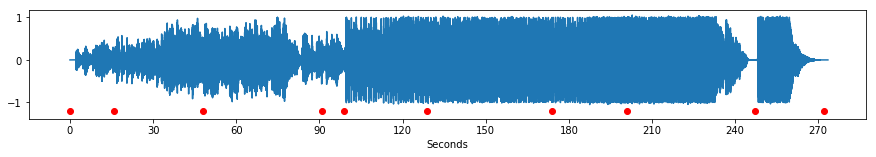

你的背包.mp3 (5294592,) 22050 240.11755102040817


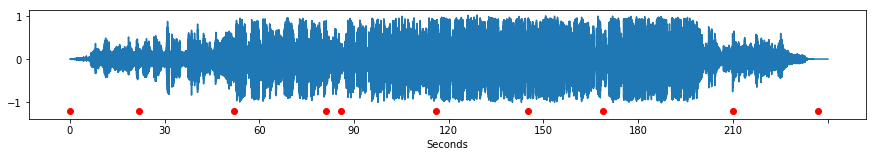

伤信.mp3 (6145920,) 22050 278.7265306122449


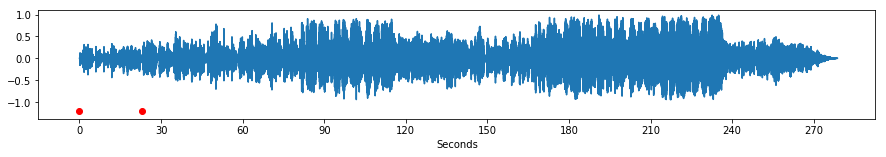

In [66]:
# 输出观察读取音乐的时间曲线
import matplotlib.pyplot as plt
import librosa
import os, sys

music_path = '../data/music/'
files = os.listdir(music_path)
for i in range(4):
    d = data.iloc[i].values
    name = d[0] + '.mp3'
    points = d[1].split(',')
    if name in files:
        tempdata, sr = librosa.load(os.path.join(music_path, name))
        # 获取音乐时长
        t = librosa.get_duration(tempdata, sr)
        print(name, tempdata.shape, sr, t)
        plt.subplots(figsize=(15, 2))
        plt.plot(range(tempdata.shape[0]), tempdata)
        # 画出转场点
        for p in points:
            ps = p.split(':')
            p = int(ps[0]) * 60 + int(ps[1])
            plt.scatter(int(p/t*tempdata.shape[0]), -1.2, c='r')
        plt.xticks(range(0, tempdata.shape[0], int(tempdata.shape[0] * 30 / t)), range(0, int(t), 30))
        plt.xlabel('Seconds')
        plt.show()

In [3]:
# 采样抽取训练数据
import librosa
import os, sys

datax = []
datay = []

music_path = '../data/music/'
files = os.listdir(music_path)
for i in range(data.shape[0]):
    d = data.iloc[i].values
    name = d[0] + '.mp3'
    points = d[1].split(',')
    for i in range(len(points)):
        s = points[i].split(':')
        try:
            points[i] = int(s[0]) * 60 + int(s[1])
        except:
            points[i] = 0

    if name in files:
        tempdata, sr = librosa.load(os.path.join(music_path, name))
        # 获取音乐时长
        t = librosa.get_duration(tempdata, sr)
        print(name, tempdata.shape, sr, t)
        i = 0
        t = 4
        while i+6*sr < tempdata.shape[0]:
            datax.append(tempdata[i: i+6*sr]) # 一个点，取前4s与后2s组成一个样本，判断这个点是不是转场点
            if t in points:
                datay.append(1)
            else:
                datay.append(0)
            i += sr
            t += 1
        
print(np.shape(datax), np.shape(datay))
print(sum(datay), len(datay)-sum(datay))
np.save('../data/datax.npy', datax)
np.save('../data/datay.npy', datay)

孤独患者.mp3 (6030336,) 22050 273.48462585034014
你的背包.mp3 (5294592,) 22050 240.11755102040817
伤信.mp3 (6145920,) 22050 278.7265306122449
淘汰.mp3 (6283264,) 22050 284.95528344671203
K歌之王.mp3 (4817664,) 22050 218.48816326530613
我总是一个人在练习一个人.mp3 (4039488,) 22050 183.19673469387754
石榴石.mp3 (7037952,) 22050 319.18149659863946
老人与海.mp3 (4250880,) 22050 192.78367346938776
那些年.mp3 (8183232,) 22050 371.1216326530612
一个人生活.mp3 (5818368,) 22050 263.87156462585034
明天以后.mp3 (5485248,) 22050 248.76408163265307
伯乐.mp3 (6044934,) 22050 274.14666666666665
你是我的眼.mp3 (6246030,) 22050 283.26666666666665
我爱的人.mp3 (5946150,) 22050 269.6666666666667
眼泪笑了（刘力扬）.mp3 (4850118,) 22050 219.96
眼色.mp3 (6215160,) 22050 281.8666666666667
自然醒.mp3 (5394816,) 22050 244.66285714285715
说谎.mp3 (5791392,) 22050 262.6481632653061
我的歌声里.mp3 (4727808,) 22050 214.4130612244898
另一个天堂.mp3 (5914624,) 22050 268.2369160997732
你不知道的事.mp3 (6152256,) 22050 279.0138775510204
心跳.mp3 (5803776,) 22050 263.2097959183673
依然爱你.mp3 (5429952,) 22050 2

In [79]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn import metrics

datax = np.array(datax)
datay = np.array(datay)

shuffle_indices = np.random.permutation(np.arange(datax.shape[0]))
datax, datay = datax[shuffle_indices], datay[shuffle_indices]

trainx, trainy = datax[:int(datax.shape[0] * 0.8)], datay[:int(datax.shape[0] * 0.8)]
testx, testy = datax[int(datax.shape[0] * 0.8):], datay[int(datax.shape[0] * 0.8):]

clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
clf.fit(trainx, trainy)
y_pred = clf.predict(testx)

print ('Precision {}\nRecall {}\nF1{}'.format(
    metrics.precision_score(y, y_pred), 
    metrics.recall_score(y, y_pred), 
    metrics.f1_score(y, y_pred)))

KeyboardInterrupt: 